# Case study on NCA dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
import multiprocessing
from worker_NCA import *
from sklearn.metrics import mean_absolute_error,root_mean_squared_error

from sklearn.decomposition import PCA
from pathlib import Path


Import preprocessed data

In [3]:
base_path = Path("")
path_save_S1 = base_path / "Processed_data"/"Stage_1"
path_save_S2 = base_path / "Processed_data"/"Stage_2"

valid_cells_S1 = np.loadtxt(path_save_S1 / "valid_cells_95.txt",dtype=str).flatten().tolist()
valid_cells_S2 = np.loadtxt(path_save_S2 / "valid_cells_95.txt",dtype=str).flatten().tolist()

# Load the feature data
feature_S1 = np.loadtxt("feature_train.csv", delimiter=',')
feature_S2 = np.loadtxt("feature_test.csv", delimiter=',')

# Load the scaled feature data
feature_S1_scaled = np.loadtxt("feature_train_scaled.csv", delimiter=',')
feature_S2_scaled = np.loadtxt("feature_test_scaled.csv", delimiter=',')

# Load the AH throughput data
N_train = np.loadtxt("ah_throughput_train.csv", delimiter=',')
N_test = np.loadtxt("ah_throughput_test.csv", delimiter=',')

# Get train/test Q matrices
Q_train = np.array([np.linspace(1,0.95,11)] * np.shape(N_train)[0])
Q_test = np.array([np.linspace(1,0.95,11)] * np.shape(N_test)[0])

Define the multiprocessing function for E2E model training/

In [11]:
def visualize_opt_res(results,plot=False):
    best_result = min(results, key=lambda x: x.fun)
    print(f"best MSE: {best_result.fun}")
    print(f"best W: {best_result.x}")

    obj_fun_values = [result.fun for result in results]
    s_or_f = np.array([result.success for result in results],dtype=int)
    if plot:
        fig,ax = plt.subplots(1,2,figsize=(6,2.5),dpi=100)
        ax[0].hist(obj_fun_values,bins=20, color='cornflowerblue', edgecolor='black')
        ax[0].set_xlabel('Objective function value')
        ax[0].set_ylabel('Frequency')

        ax[1].hist(s_or_f,color='cornflowerblue', edgecolor='black')
        ax[1].set_xlabel('Success/fail')
        ax[1].set_ylabel('Frequency')
        plt.tight_layout(pad=0.1)
        plt.show()
    return best_result

def empirical_model(c1,c2,N_eq,c_weight=[1e-3,1e-2]):
    # Match the scaling for end-to-end formulation
    c1_scaled = c1 * c_weight[0]
    c2_scaled = c2 * c_weight[1]
    return 1 - c1_scaled*N_eq**c2_scaled

def train_e2e_multiprocess(feature, start_sample, Q_train, N_train, method='SLSQP', param_bnd=(-10, 10),c_weight=[1e-3,1e-2]):
    # Use ProcessPool from pathos
    with multiprocessing.Pool() as pool:
        results = pool.starmap(
            worker,
            [(W0, feature, Q_train, N_train, method, param_bnd,c_weight) for W0 in start_sample]
        )

    best_result = visualize_opt_res(results,plot=False)
    return results, best_result

In [12]:
# Initialize the multistart for case 1 and case 2 (5 features + 1 intercept)
param_bnd=(-10,10)
num_start = 1000
sampler=qmc.LatinHypercube(d=6*2,seed=215)
sample = sampler.random(n=num_start)
lhs_lb = [param_bnd[0]+1e-2 for i in range(6*2)]
lhs_ub = [param_bnd[1]-1e-2 for i in range(6*2)]
sample_scaled_6 = qmc.scale(sample,lhs_lb,lhs_ub)

# Initialize the multistart for case 3 (10 features + 1 intercept)
sampler=qmc.LatinHypercube(d=11*2,seed=215)
sample = sampler.random(n=num_start)
lhs_lb = [param_bnd[0]+1e-2 for i in range(11*2)]
lhs_ub = [param_bnd[1]-1e-2 for i in range(11*2)]
sample_scaled_11 = qmc.scale(sample,lhs_lb,lhs_ub)


# Case 1: Only cycling condition parameters

In [37]:
X_train_case1 = np.concatenate((np.ones((feature_S1_scaled.shape[0],1)),feature_S1_scaled[:,:5]), axis=1)
X_test_case1 = np.concatenate((np.ones((feature_S2_scaled.shape[0],1)),feature_S2_scaled[:,:5]), axis=1)

c_weight = [1e-3,5e-2]
results_case1, best_result_case1 = train_e2e_multiprocess(X_train_case1, 
                                                          sample_scaled_6, 
                                                          Q_train, 
                                                          N_train, 
                                                          method='SLSQP', 
                                                          param_bnd=param_bnd,
                                                          c_weight=c_weight)

# Extract best W from case 1
best_W_case1 = best_result_case1.x.reshape(6,2)

best MSE: 0.0013442330589521277
best W: [ 0.53557502 10.          0.16076369 -0.21451543  0.12549978 -0.1573935
  0.06086879 -0.33318185 -0.03939315  0.20447434  0.11078395 -0.71619835]


Evaluate the performance

In [38]:
c_train_hat_case1 = np.abs(X_train_case1 @ best_W_case1)
c_test_hat_case1 = np.abs(X_test_case1 @ best_W_case1)

# Evaluate the accuracy of the model
# Evaluate training performance
Q_train_hat_case1 = Q_train.copy()
RMSE_train_case1 = []
MAE_train_case1 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    [c1,c2] = c_train_hat_case1[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_train_hat_case1[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_train_case1.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_train_case1.append(MAE)

# Evaluate test performance
Q_test_in_hat_case1 = Q_test.copy()
RMSE_test_in_case1 = []
MAE_test_in_case1 = []
for iii in range(len(Q_test)):
    Q_true = Q_test[iii]
    N_true = N_test[iii]
    [c1,c2] = c_test_hat_case1[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_test_in_hat_case1[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_test_in_case1.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_test_in_case1.append(MAE)

print(f"Case 1: Train RMSE: {np.mean(RMSE_train_case1):.4f}, Test RMSE: {np.mean(RMSE_test_in_case1):.4f}")
print(f"Case 1: Train MAE: {np.mean(MAE_train_case1):.4f}, Test MAE: {np.mean(MAE_test_in_case1):.4f}")

Case 1: Train RMSE: 0.0033, Test RMSE: 0.0076
Case 1: Train MAE: 0.0027, Test MAE: 0.0061


# Case 2: Only extracted early life features

In [41]:
c_weight = [1e-3,5e-2]
X_train_case2 = np.concatenate((np.ones((feature_S1_scaled.shape[0],1)),feature_S1_scaled[:,5:]), axis=1)
X_test_case2 = np.concatenate((np.ones((feature_S2_scaled.shape[0],1)),feature_S2_scaled[:,5:]), axis=1)


results_case2, best_result_case2 = train_e2e_multiprocess(X_train_case2, 
                                                          sample_scaled_6, 
                                                          Q_train, 
                                                          N_train, 
                                                          method='SLSQP', 
                                                          param_bnd=param_bnd,
                                                          c_weight=c_weight)

# Extract best W from case 1
best_W_case2 = best_result_case2.x.reshape(6,2)

best MSE: 0.005767798319625085
best W: [ 1.55740847  7.33911282 -2.29486579 -3.07798036  2.39209395  2.73785296
  0.01650777  0.23461146  0.3300239  -0.27805436 -0.67470827  0.85974701]


Evaluate the performance

In [42]:
c_train_hat_case2 = np.abs(X_train_case2 @ best_W_case2)
c_test_hat_case2 = np.abs(X_test_case2 @ best_W_case2)

# Evaluate the accuracy of the model
# Evaluate training performance
Q_train_hat_case2 = Q_train.copy()
RMSE_train_case2 = []
MAE_train_case2 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    [c1,c2] = c_train_hat_case2[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_train_hat_case2[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_train_case2.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_train_case2.append(MAE)

# Evaluate test performance
Q_test_in_hat_case2 = Q_test.copy()
RMSE_test_in_case2 = []
MAE_test_in_case2 = []
for iii in range(len(Q_test)):
    Q_true = Q_test[iii]
    N_true = N_test[iii]
    [c1,c2] = c_test_hat_case2[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_test_in_hat_case2[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_test_in_case2.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_test_in_case2.append(MAE)

print(f"Case 2: Train RMSE: {np.mean(RMSE_train_case2):.4f}, Test RMSE: {np.mean(RMSE_test_in_case2):.4f}")
print(f"Case 2: Train MAE: {np.mean(MAE_train_case2):.4f}, Test MAE: {np.mean(MAE_test_in_case2):.4f}")

Case 2: Train RMSE: 0.0072, Test RMSE: 0.0083
Case 2: Train MAE: 0.0060, Test MAE: 0.0070


# Case 3: Cycling conditions plus extracted early-life features

In [51]:
c_weight = [5e-4,5e-2]

pca_model = PCA(n_components=5)
X_train_PCA = pca_model.fit_transform(feature_S1_scaled)
X_test_PCA = pca_model.transform(feature_S2_scaled)

X_train_case3 = np.concatenate((np.ones((feature_S1_scaled.shape[0],1)),X_train_PCA), axis=1)
X_test_case3 = np.concatenate((np.ones((feature_S2_scaled.shape[0],1)),X_test_PCA), axis=1)


results_case3, best_result_case3 = train_e2e_multiprocess(X_train_case3, 
                                                          sample_scaled_6, 
                                                          Q_train, 
                                                          N_train, 
                                                          method='SLSQP', 
                                                          param_bnd=param_bnd,
                                                          c_weight=c_weight)

# Extract best W from case 1
best_W_case3 = best_result_case3.x.reshape(6,2)

best MSE: 0.004000331864575265
best W: [ 1.90545850e+00  8.55603978e+00 -5.21742139e-03 -9.43715876e-02
  3.35609970e-01 -6.51368773e-01 -3.50320848e-01  2.02896214e-01
 -6.70418335e-02 -2.95820019e-02 -2.66970613e-01  4.87306944e-01]


Evaluate the performance

In [52]:
c_train_hat_case3 = np.abs(X_train_case3 @ best_W_case3)
c_test_hat_case3 = np.abs(X_test_case3 @ best_W_case3)

# Evaluate the accuracy of the model
# Evaluate training performance
Q_train_hat_case3 = Q_train.copy()
RMSE_train_case3 = []
MAE_train_case3 = []
for iii in range(len(Q_train)):
    Q_true = Q_train[iii]
    N_true = N_train[iii]
    [c1,c2] = c_train_hat_case3[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_train_hat_case3[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_train_case3.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_train_case3.append(MAE)

# Evaluate test performance
Q_test_in_hat_case3 = Q_test.copy()
RMSE_test_in_case3 = []
MAE_test_in_case3 = []
for iii in range(len(Q_test)):
    Q_true = Q_test[iii]
    N_true = N_test[iii]
    [c1,c2] = c_test_hat_case3[iii]
    Q_pred = empirical_model(c1,c2,N_true,c_weight)
    Q_test_in_hat_case3[iii] = Q_pred

    RMSE = root_mean_squared_error(Q_true,Q_pred)
    RMSE_test_in_case3.append(RMSE)
    MAE = mean_absolute_error(Q_true,Q_pred)
    MAE_test_in_case3.append(MAE)

print(f"Case 3: Train RMSE: {np.mean(RMSE_train_case3):.4f}, Test RMSE: {np.mean(RMSE_test_in_case3):.4f}")
print(f"Case 3: Train MAE: {np.mean(MAE_train_case3):.4f}, Test MAE: {np.mean(MAE_test_in_case3):.4f}")

Case 3: Train RMSE: 0.0055, Test RMSE: 0.0087
Case 3: Train MAE: 0.0046, Test MAE: 0.0069


# Visualize the prediction

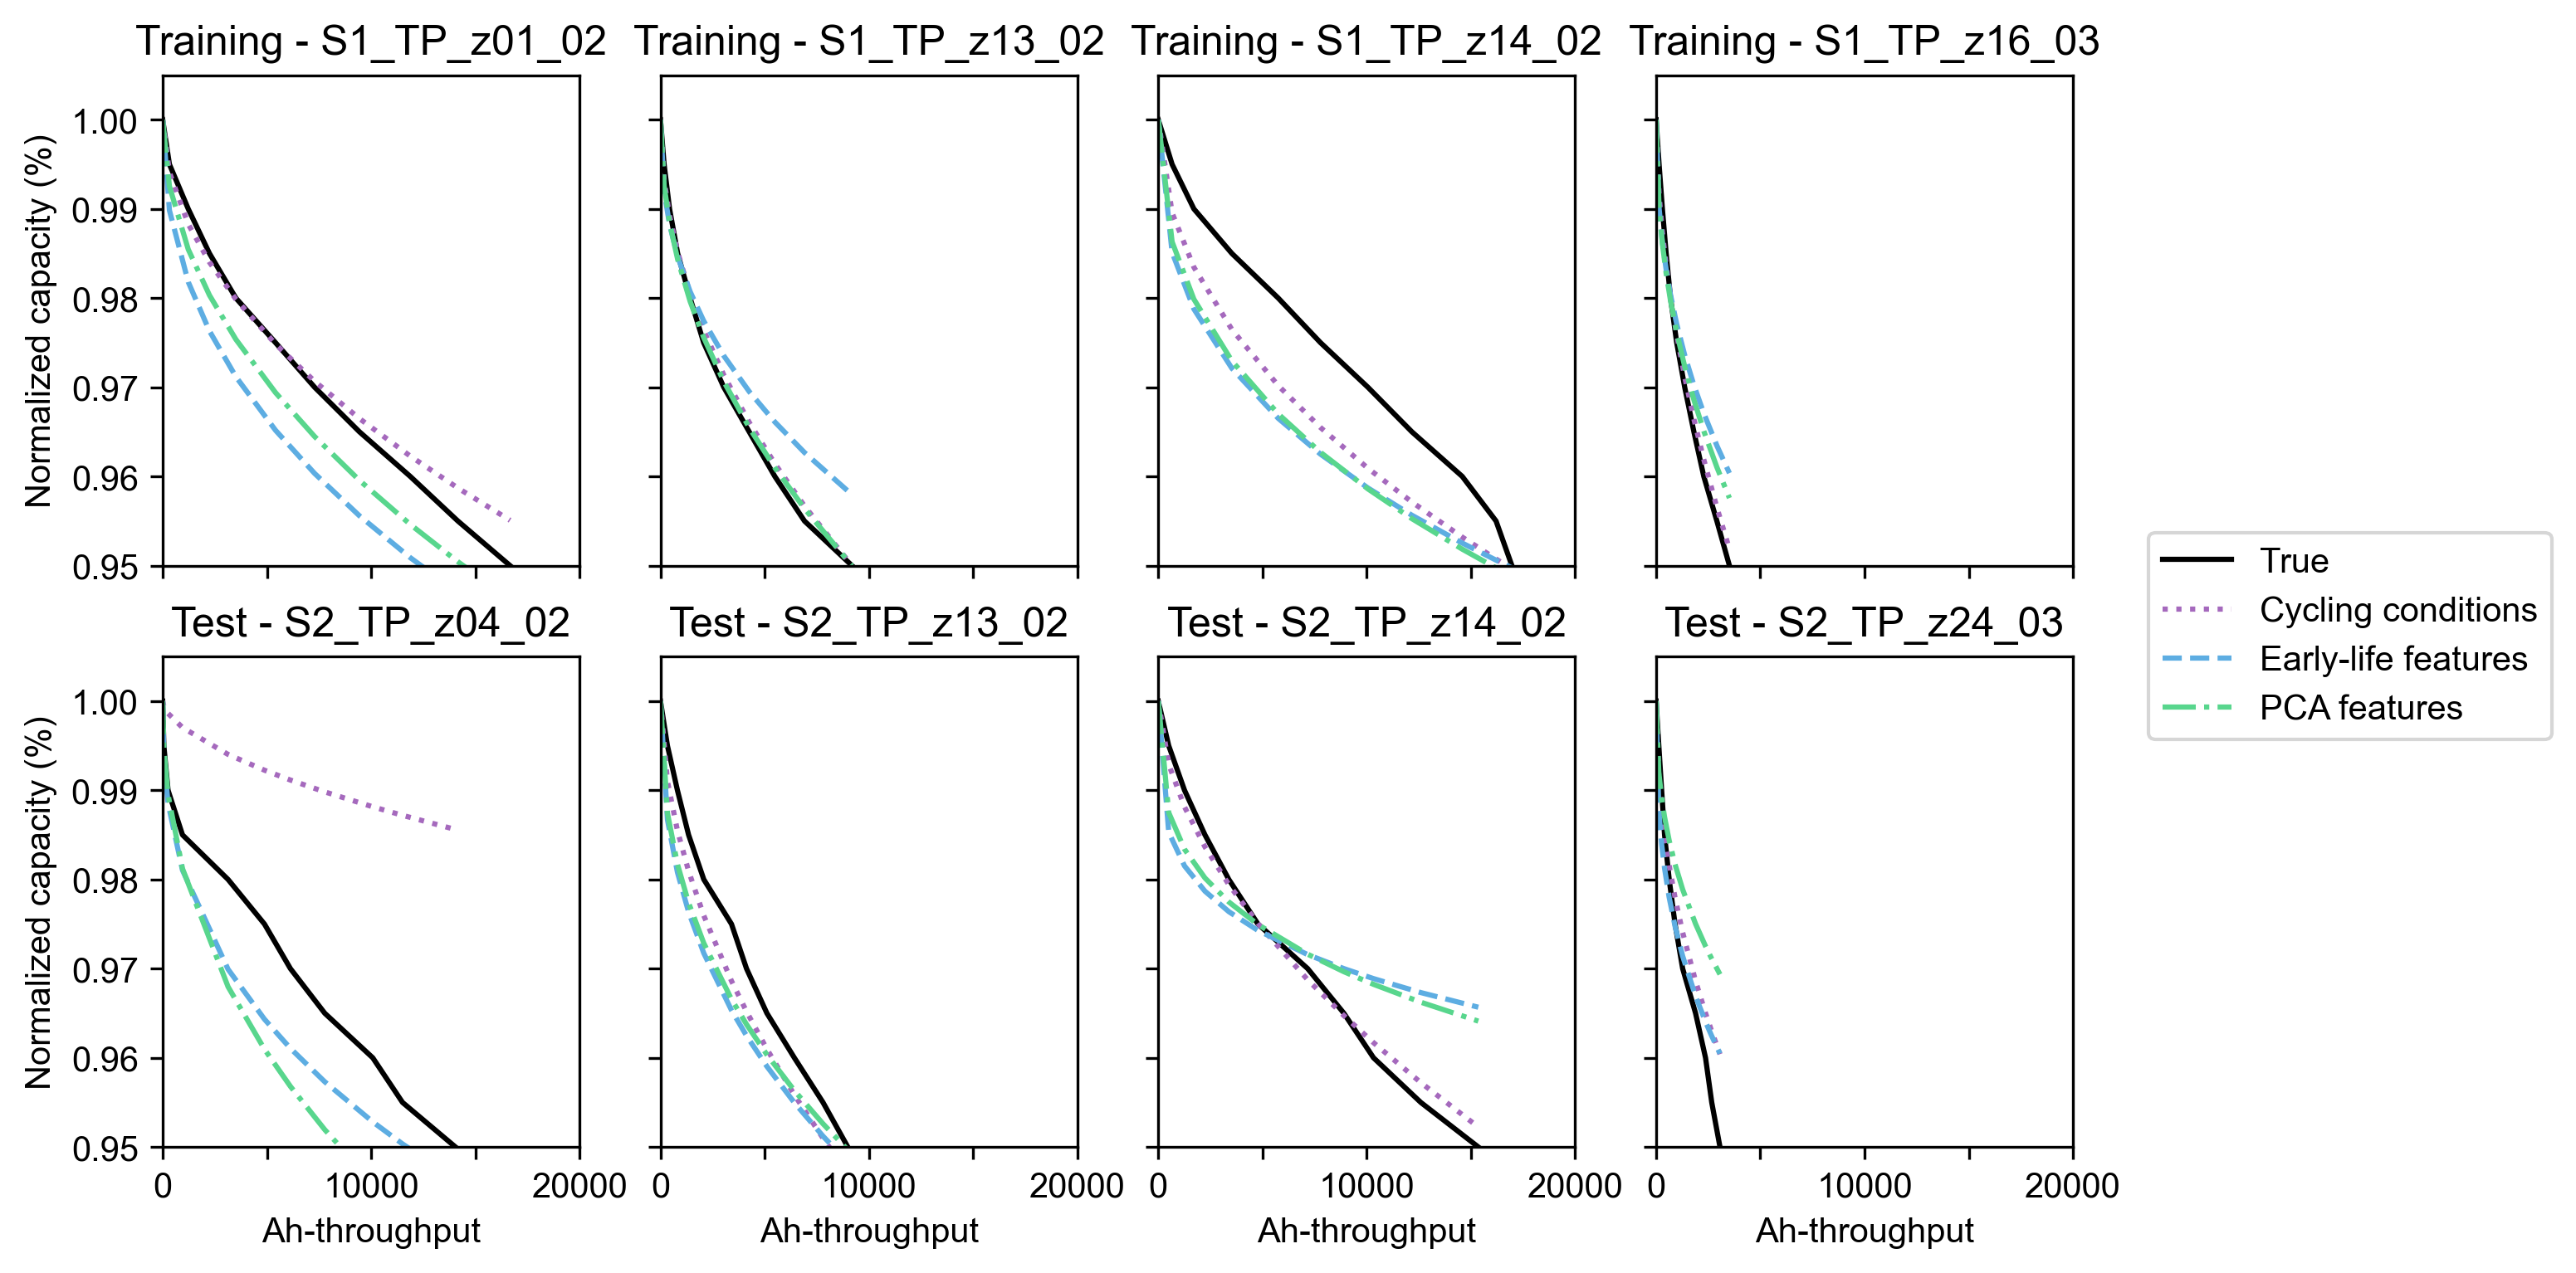

In [ ]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

fig, axes = plt.subplots(2, 4, figsize=(8.5, 5), dpi=300,sharex=True,sharey=True, constrained_layout=True)
colors = ['#a569bd', '#5dade2', '#58d68d', '#f5b041']
linestyle = [':', '--', '-.']

# Plot four cells from training samples
for idx, iii in enumerate([1, 18, 21, 27]):
    N = N_train[iii]
    axes[0, idx].plot(N, Q_train[iii], 'k-', label='True')
    axes[0, idx].plot(N, Q_train_hat_case1[iii], label='Cycling conditions', color=colors[0], linestyle=linestyle[0])
    axes[0, idx].plot(N, Q_train_hat_case2[iii], label='Early-life features', color=colors[1], linestyle=linestyle[1])
    axes[0, idx].plot(N, Q_train_hat_case3[iii], label='PCA features', color=colors[2], linestyle=linestyle[2])
    axes[0, idx].set_title(f'Training - S1_{valid_cells_S1[iii]}')
    axes[0, idx].set_xlim([0, 20000])
    if valid_cells_S1[iii] == 'TP_z19_02' or valid_cells_S1[iii] == 'TP_z19_03':
        axes[0, idx].set_xlim([0, 30000])
    axes[0, idx].set_ylim([0.95, 1.005])


# Plot four cells from test samples
for idx, iii in enumerate([4, 19, 22, 42]):
    N = N_test[iii]
    axes[1, idx].plot(N, Q_test[iii], 'k-', label='True')
    axes[1, idx].plot(N, Q_test_in_hat_case1[iii], label='Cycling conditions', color=colors[0], linestyle=linestyle[0])
    axes[1, idx].plot(N, Q_test_in_hat_case2[iii], label='Early-life features', color=colors[1], linestyle=linestyle[1])
    axes[1, idx].plot(N, Q_test_in_hat_case3[iii], label='PCA features', color=colors[2], linestyle=linestyle[2])
    axes[1, idx].set_title(f'Test - S2_{valid_cells_S2[iii]}')
    axes[1, idx].set_xlim([0, 20000])
    axes[1, idx].set_ylim([0.95, 1.005])
    axes[1, idx].set_xticks([0, 5000, 10000, 15000, 20000])
    axes[1, idx].set_xticklabels([0, '', 10000, '', 20000])

# Create a single shared legend outside the plots
handles, labels = axes[1, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))

for iii in range(2):
    axes[iii, 0].set_ylabel('Normalized capacity (%)')

for iii in range(4):
    axes[1, iii].set_xlabel('Ah-throughput')

# plt.subplots_adjust(right=.98)  # Adjust space to fit the legend
# plt.tight_layout()

plt.show()